# Lunar Gateway Link Budget

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pylink
import SystemDefinition
from utils import Loader
import pickle

import warnings
warnings.filterwarnings('ignore') # this prevents a warning that comes from the ITU library - need to check this

## Lunar Gateway Amateur Radio Transponder

The upcoming Lunar Gateway will be hosting an amateur radio transponder.  The following analysis examines the space to earth link.

The aim is to determine the dimensioning of the system to deliver the expected system performance.  The size of the spacecraft antenna is fixed by the need for $ \approx 40 ^{\circ} $ of beamwidth which gives $ \approx 10~dB $ gain at $ 10 ~ GHz $.

We will examine what transmit power is required to close the link in this configuration as well as the achievable datarates using the DVB-S2X standard.

Finally with a chosen transmit power a Monte-Carlo simulation is performed to gain an insight into the statistical properties of the link.

### Import the configuration files

In [3]:
satellite_configuration = Loader.load_configuration('configs/satellite-lunar.yaml')
channel_configuration = Loader.load_configuration('configs/channel-lunar.yaml')
groundstation_configuration = Loader.load_configuration('configs/groundstation-tvdish.yaml') 

# Find Datarate over Receive Dish Diameter

Here we will vary the diameter of the receive dish and find the link margin and achievable datarates.

For this simulation the symbol rate is 80 ksps for 100 kHz of occupied bandwidth.

In [10]:
# define the parameters to vary
rx_antenna_diameter = np.linspace(0.5, 5, 30)
tx_power = np.linspace(9.0, 24.0, 6)

# collect these parameters
rx_power = np.zeros((len(rx_antenna_diameter), len(tx_power)))
link_margin = np.zeros((len(rx_antenna_diameter), len(tx_power)))
datarate = np.zeros((len(rx_antenna_diameter), len(tx_power)))

# loop through each PA power
for j in range(len(tx_power)):

    # set the new PA power
    satellite_configuration['nominal']['tx']['pa']['power'] = tx_power[j]
    
    for i in range(len(rx_antenna_diameter)):
        
        # set the new Rx antenna diameter
        rx_antenna_aperture = np.pi * (rx_antenna_diameter[i]/2)**2
        groundstation_configuration['nominal']['rx']['antenna']['aperture'] = rx_antenna_aperture
        
        # solve the system
        system = SystemDefinition.SystemDefinition( satellite_configuration,
                                                    groundstation_configuration,
                                                    channel_configuration,
                                                    warn=False)
        # find the performance parameters
        rx_power[i][j], link_margin[i][j], datarate[i][j] = system.link_metrics()

### Plot the link margin

<IPython.core.display.Javascript object>


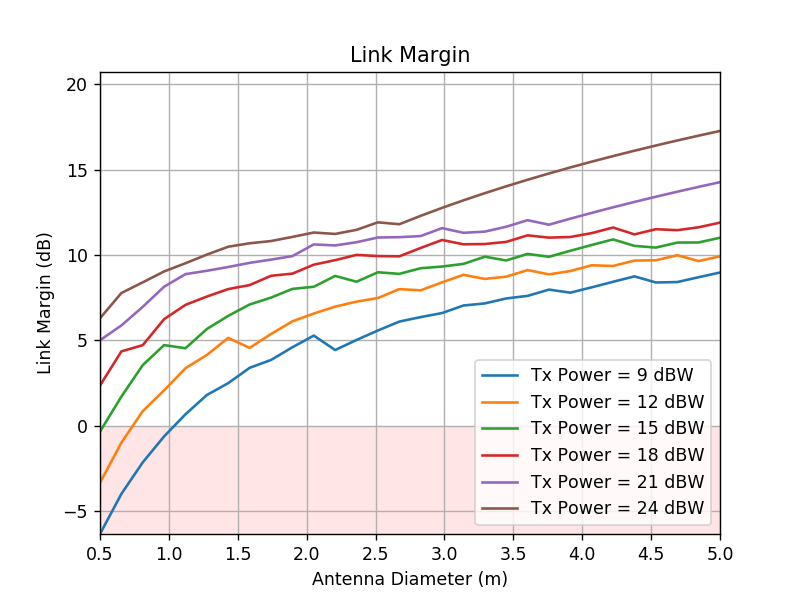

In [11]:
plt.figure()
for i in range(len(tx_power)):
    plt.plot(rx_antenna_diameter, link_margin[:,i])

# plot broken link
min_value = min(link_margin.flatten())
max_value = max(link_margin.flatten())
plt.fill_between([-1.2*rx_antenna_diameter[0], 1.2*rx_antenna_diameter[-1]], [0,0], 2*min_value, facecolor="red", alpha=0.1)
plt.xlim([rx_antenna_diameter[0], rx_antenna_diameter[-1]])
plt.ylim([min_value, max_value*1.2])

# label
plt.legend([('Tx Power = %d dBW'%_) for _ in tx_power])
plt.xlabel('Antenna Diameter (m)')
plt.ylabel('Link Margin (dB)')
plt.title('Link Margin')
plt.grid()
plt.show()

### Plot the achievable datarates

<IPython.core.display.Javascript object>


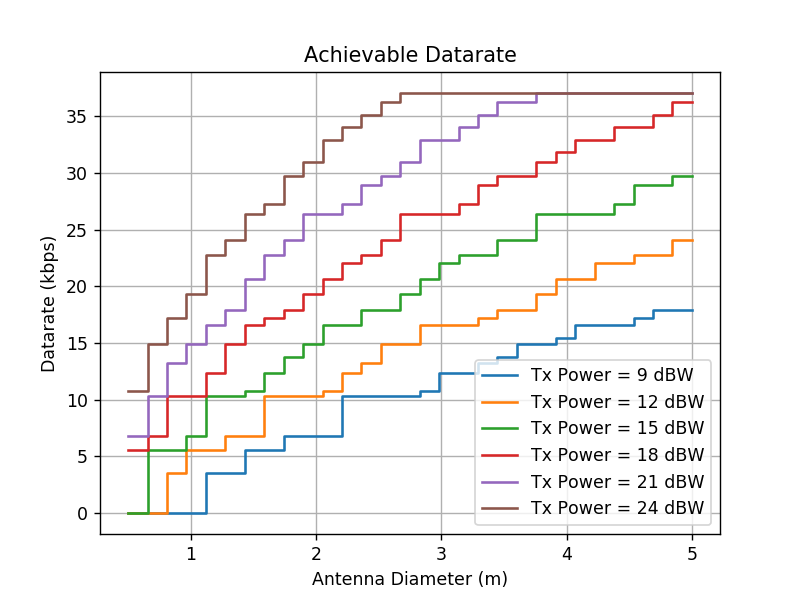

In [12]:
plt.figure()
for i in range(len(tx_power)):
    plt.step(rx_antenna_diameter, datarate[:,i]/1e3, where='post')

plt.legend([('Tx Power = %d dBW'%_) for _ in tx_power])
plt.xlabel('Antenna Diameter (m)')
plt.ylabel('Datarate (kbps)')
plt.title('Achievable Datarate')
plt.grid()
plt.show()

### Print the system details

This breaks down some system parameters for the most recent (and most optimistic) analysis case 

In [13]:
system.print_link_info('downlink')

Elevation (degress):             89
Slant Range (km):               384401
Antenna Angle (deg):            0.0163208
Total Rx Noise Temperature (K): 421.614
Receiver Noise Temperature (K): 121.614
Noise Factor:                   1.41936
Noise Figure (dB):              1.52092
Transmit Power (dBW):            24
Transmit EIRP (dBW):            34.9916
UGPL (dB):                      224.547
Total Channel Loss (dB):        226.288
Link Margin (dB):               17.2636
Noise BW Loss (dB):             0  
C / N0 (dB):                    63.1244
Rx Power (dBW):                 -139.226
Rx N0 (dBW/Hz):                 -202.35
Eb / N0 (dB):                   29.1244
Eb (dB):                        -173.226
Bitrate Hz (dB):                34 
=== Modulation: DVB-S2X ===
  Best Code:                    256APSK 3/4
  Transmit Spectral Efficiency: 4.720684
  Receive Spectral Efficiency:  5.900855
  Required Es/N0:               19.570000
  Required Eb/N0:               11.860851
  Achieved Data

# Analyse the Effect of Symbol Rate

Here we will vary the symbol rate and look at how this affects the ability to close the link.

We will set the power amplifier output power constant at 13 dBW (20 W).

In [14]:
# define the parameters to vary
rx_antenna_diameter = np.linspace(0.5, 5, 30)
symbolrate = np.logspace(3, 5, 6, endpoint=True)

# collect these parameters
rx_power = np.zeros((len(rx_antenna_diameter), len(symbolrate)))
link_margin = np.zeros((len(rx_antenna_diameter), len(symbolrate)))
datarate = np.zeros((len(rx_antenna_diameter), len(symbolrate)))

# set the PA power
satellite_configuration['nominal']['tx']['pa']['power'] = 13

# loop through each PA power
for j in range(len(symbolrate)):

    # set the new symbol rate
    channel_configuration['nominal']['downlink']['bitrate'] = symbolrate[j]
    channel_configuration['nominal']['downlink']['allocation'] = 2.5*symbolrate[j]    
    
    for i in range(len(rx_antenna_diameter)):
        
        # set the new Rx antenna diameter
        rx_antenna_aperture = np.pi * (rx_antenna_diameter[i]/2)**2
        groundstation_configuration['nominal']['rx']['antenna']['aperture'] = rx_antenna_aperture
        
        # solve the system
        system = SystemDefinition.SystemDefinition( satellite_configuration,
                                                    groundstation_configuration,
                                                    channel_configuration,
                                                    warn=False)
        # find the performance parameters
        rx_power[i][j], link_margin[i][j], datarate[i][j] = system.link_metrics()

### Plot the link margin

Note that the link margin is to the selected best MODCON available.  However, a negative link margin means the link does not close.

<IPython.core.display.Javascript object>


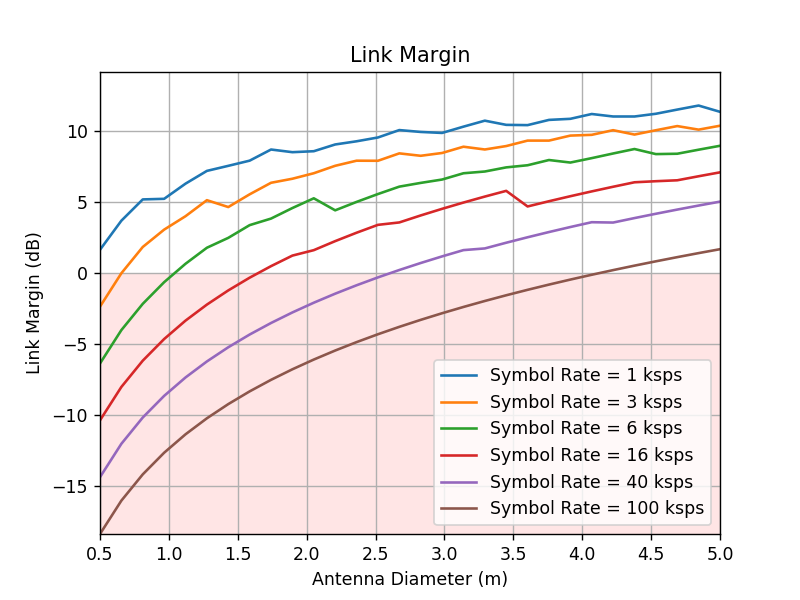

In [15]:
plt.figure()
for i in range(len(symbolrate)):
    plt.plot(rx_antenna_diameter, link_margin[:,i])

# plot broken link
min_value = min(link_margin.flatten())
max_value = max(link_margin.flatten())
plt.fill_between([-1.2*rx_antenna_diameter[0], 1.2*rx_antenna_diameter[-1]], [0,0], 2*min_value, facecolor="red", alpha=0.1)
plt.xlim([rx_antenna_diameter[0], rx_antenna_diameter[-1]])
plt.ylim([min_value, max_value*1.2])

# label
plt.legend([('Symbol Rate = %0.0f ksps'%_) for _ in symbolrate/1e3])
plt.xlabel('Antenna Diameter (m)')
plt.ylabel('Link Margin (dB)')
plt.title('Link Margin')
plt.grid()
plt.show()

### Plot the achievable datarates

<IPython.core.display.Javascript object>


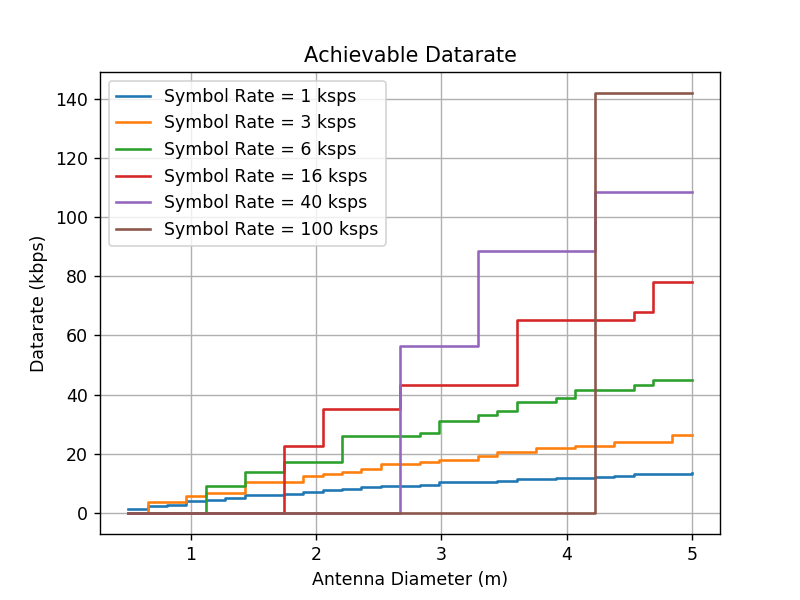

In [16]:
plt.figure()
for i in range(len(symbolrate)):
    plt.step(rx_antenna_diameter, datarate[:,i]/1e3, where='post')

plt.legend([('Symbol Rate = %0.0f ksps'%_) for _ in symbolrate/1e3])
plt.xlabel('Antenna Diameter (m)')
plt.ylabel('Datarate (kbps)')
plt.title('Achievable Datarate')
plt.grid()
plt.show()

# Perform a Monte-Carlo Simulation

### Selected Parameters

We will select a power amplifier power of 13 dBW (20 W) and a symbol rate of 80 ksps for this simulation.

### Monte-Carlo Description

A Monte-Carlo simulation calculates the link performance many times each time drawing values from the statistical distribution of each parameter. By repeating this process many times the statistical performance overall can be determined.

The distributions for each element are defined in the associated configuration files. For example, the elevation is randomly varied between 5 $^{\circ}$ and 90 $^{\circ}$.  The slant range and the propagation losses using the ITU models are re-calculated for the selected elevation.  Each variable, (gain, noise figure, etc.) can have a statistical distribution assigned to it.

It could take a while to run the simulation...

In [21]:
# set the new PA power
satellite_configuration['nominal']['tx']['pa']['power'] = 13
channel_configuration['nominal']['downlink']['bitrate'] = 40e3      # the lowest datarate is 0.5 bits/symbols
channel_configuration['nominal']['downlink']['allocation'] = 100e3 

mc_length = 1000
rx_antenna_diameter = np.linspace(0.5, 10, 30)

rx_power_mc = np.zeros((len(rx_antenna_diameter), 7))
link_margin_mc = np.zeros((len(rx_antenna_diameter), 7))
datarate_mc = np.zeros((len(rx_antenna_diameter), 7))

# loop through each elevation
for j in range(len(rx_antenna_diameter)):
    
    rx_power_mc_run = np.zeros(mc_length)
    link_margin_mc_run = np.zeros(mc_length)
    datarate_mc_run = np.zeros(mc_length)
    
    # update the receive antenna diameter
    rx_antenna_aperture = np.pi * (rx_antenna_diameter[j]/2)**2
    groundstation_configuration['nominal']['rx']['antenna']['aperture'] = rx_antenna_aperture
    
    # run through the Monte-Carlo iterations
    for i in range(mc_length):
        system = SystemDefinition.SystemDefinition( satellite_configuration,
                                                    groundstation_configuration,
                                                    channel_configuration,
                                                    monte_carlo=True,
                                                    warn=False)
        rx_power_mc_run[i], link_margin_mc_run[i], datarate_mc_run[i] = system.link_metrics()

    # find the signal statistics
    rx_power_mc[j] = system.find_confidence_intervals(rx_power_mc_run)
    link_margin_mc[j] = system.find_confidence_intervals(link_margin_mc_run)
    datarate_mc[j] = system.find_confidence_intervals(datarate_mc_run)

with open('lunar_mc.pkl', 'wb') as f:
    pickle.dump([rx_antenna_diameter, rx_power_mc, link_margin_mc, datarate_mc], f)

In [22]:
with open('lunar_mc.pkl', 'rb') as f:
    rx_antenna_diameter, rx_power_mc, link_margin_mc, datarate_mc = pickle.load(f)

### Plot the Results

We will plot the statistical data.  The median, 25%, 50% and 75% confidence intervals are shown.

Note that the distribution is not symmetric, ie. the skewness and kurtosis is non-zero.  Therefore, mean is not an appropriate measure of the peak of the probability density function.

<IPython.core.display.Javascript object>


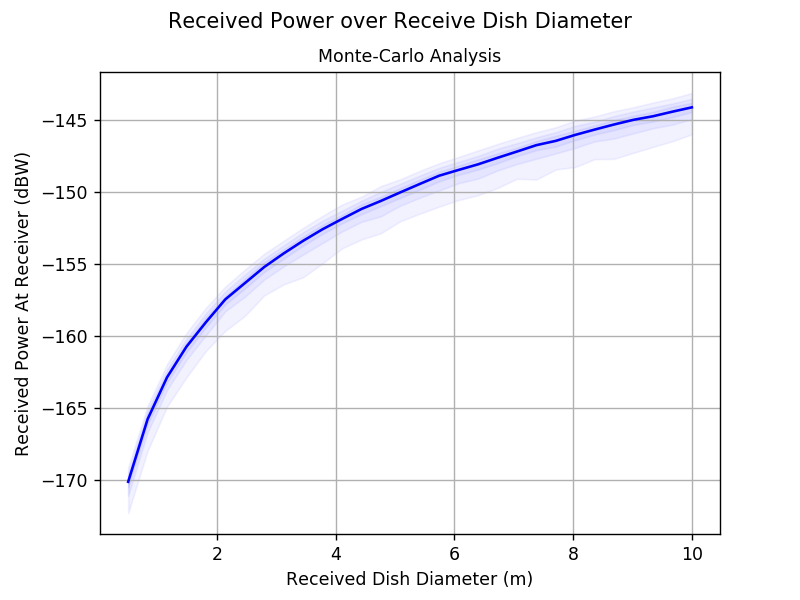

In [23]:
system.plot_confidence_intervals(rx_antenna_diameter, rx_power_mc, 
                                 ['Received Power over Receive Dish Diameter', 
                                  'Received Dish Diameter (m)',
                                  'Received Power At Receiver (dBW)'])

<IPython.core.display.Javascript object>


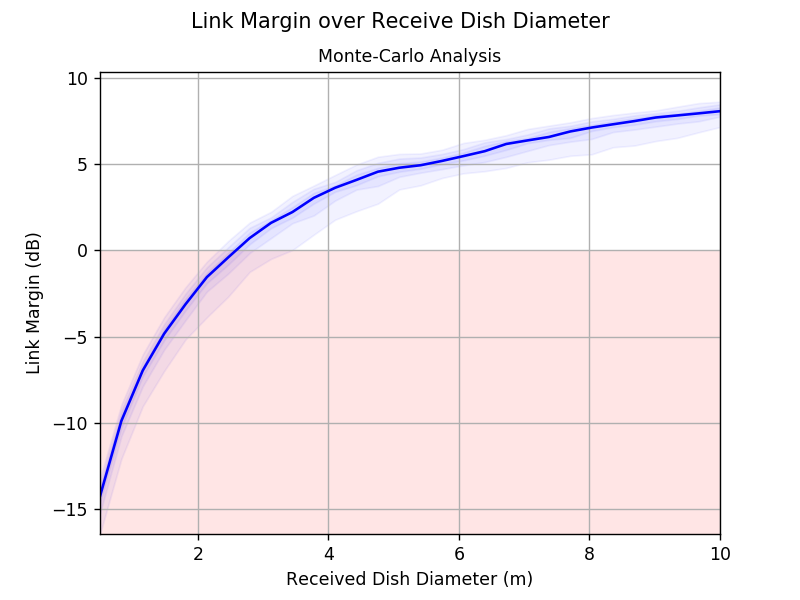

In [25]:
system.plot_confidence_intervals(rx_antenna_diameter, link_margin_mc, 
                                 ['Link Margin over Receive Dish Diameter', 
                                  'Received Dish Diameter (m)',
                                  'Link Margin (dB)'],
                                  negative_shade=True)

<IPython.core.display.Javascript object>


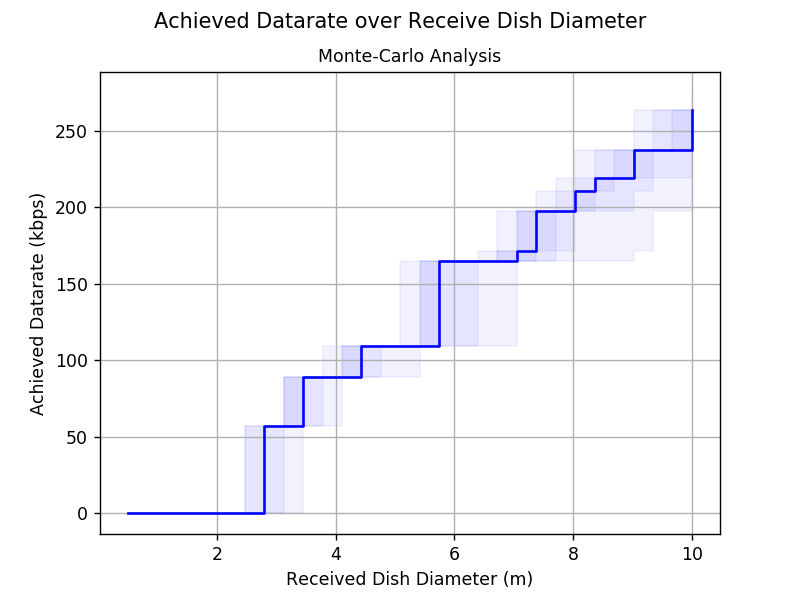

In [27]:
system.plot_confidence_intervals(rx_antenna_diameter, datarate_mc/1e3, 
                                 ['Achieved Datarate over Receive Dish Diameter', 
                                  'Received Dish Diameter (m)',
                                  'Achieved Datarate (kbps)'],
                                  step=True)